# LCP Feature Extraction

In [13]:
#Import necessary modules
import numpy as np
import pandas as pd
import librosa
from matplotlib import pyplot as plt
import seaborn as sns

In [14]:
#Load npy files
sub = np.load('../../All_audio_sub_files.npy',allow_pickle=True)
all_emo = np.load('../../emotion_dictionary_format.npy',allow_pickle=True)


In [15]:
# Convert NumPy array to normal dictionary
emo_dict = dict(all_emo.item())
# print(emo_dict)

In [16]:
suball=[]
for i in sub:
    suball.append("../../"+i)

## Experiments (Not part of analysis)

In [17]:
def bac(x, p):
    # compute the biased autocorrelation for x up to lag p
    L = len(x)
    r = np.zeros(p+1)
    for m in range(0, p+1):
        for n in range(0, L-m):
            r[m] += x[n] * x[n+m]
        r[m] /= float(L)
    return r

In [18]:
def ld(r, p):
    # solve the toeplitz system using the Levinson-Durbin algorithm
    g = r[1] / r[0]
    a = np.array([g])
    v = (1. - g * g) * r[0];
    for i in range(1, p):
        g = (r[i+1] - np.dot(a, r[1:i+1])) / v
        a = np.r_[ g,  a - g * a[i-1::-1] ]
        v *= 1. - g*g
    # return the coefficients of the A(z) filter
    return np.r_[1, -a[::-1]]     

In [19]:
def lpc(x, p):
    # compute p LPC coefficients for a speech segment
    return ld(bac(x, p), p)

In [20]:
def plot_spec(x, Fs, max_freq=None, do_fft=True):
    C = int(len(x) / 2)  # positive frequencies only
    if max_freq:
        C = int(C * max_freq / float(Fs) * 2) 
    X = np.abs(np.fft.fft(x)[0:C]) if do_fft else x[0:C]
    N = Fs * np.arange(0, C) / len(x);
    plt.plot(N, X)
    return N, X

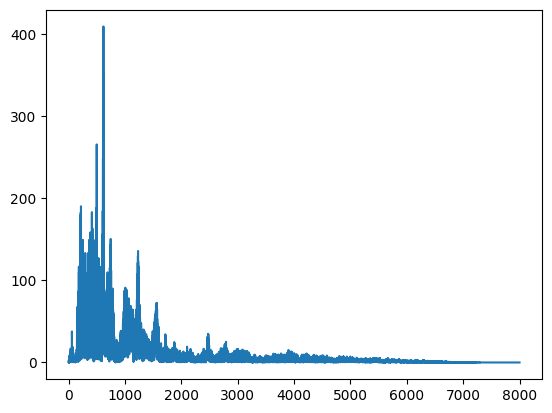

In [21]:
s, Fs = librosa.load(suball[5])

plot_spec(s, Fs, 8000);

In [32]:
# plot_spec(y, Fs_y)
# A = np.fft.fft(lpc(y, 20), len(y))
# plot_spec(np.abs(np.divide(1.0, A)), Fs_y, do_fft=False);

## Extract Features

In [23]:
def extract_lpcc_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path)
    
    # Extract LPCC features
    lpcc_features = librosa.lpc(y=y,order=10)

    # Return the features
    return lpcc_features

In [24]:
lcppfeatures = []
lcpplabels = []

for filename in suball:
    try:
        lcpp = extract_lpcc_features(filename)
        lcppfeatures.append(lcpp)
        lcpplabel = emo_dict[filename.split('/')[-1].replace('.wav','')]
        lcpplabels.append(lcpplabel)
    except:
        print(filename)

C:\Users\sreev\AppData\Local\Temp\ipykernel_36336\1676844072.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
C:\Users\sreev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


../../../IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F025.pk
../../../IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F019.pk
../../../IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F041.pk
../../../IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F011.pk


## Create Dataframe

In [25]:
cole = [f'LCP{i+1}' for i in range(len(lcppfeatures[0]))]
df_lcpp = pd.DataFrame(lcppfeatures, columns=cole)

In [26]:
df_lcpp['Label'] = lcpplabels

In [27]:
indexAge = df_lcpp[ (df_lcpp['Label'] == 'xxx') | (df_lcpp['Label'] == 'dis') | (df_lcpp['Label'] == 'hap') |(df_lcpp['Label'] == 'fru') | (df_lcpp['Label'] == 'neu') | (df_lcpp['Label'] == 'fea') | (df_lcpp['Label'] == 'sur') | (df_lcpp['Label'] == 'oth')].index
df_lcpp.drop(indexAge, inplace=True)
df_lcpp['Label'].value_counts()

Label
ang    1103
sad    1084
exc    1041
Name: count, dtype: int64

In [28]:
df_lcpp.head()

,LCP1,LCP2,LCP3,LCP4,LCP5,LCP6,LCP7,LCP8,LCP9,LCP10,LCP11,Label
12,1.0,-4.620619,11.216498,-18.965210,24.804852,-26.135841,22.393353,-15.348988,8.033381,-2.891480,0.543560,ang
27,1.0,-4.243772,9.878223,-16.549742,21.832207,-23.426395,20.516266,-14.562426,8.120422,-3.267545,0.721418,ang
29,1.0,-4.550903,10.997309,-18.775156,24.923088,-26.633648,23.093740,-16.064711,8.651243,-3.271798,0.654612,ang
30,1.0,50.537933,-286.185974,745.173340,-1258.394165,1555.833252,-1455.320068,1020.872925,-502.843231,140.464554,-10.920460,sad
31,1.0,125.109383,-540.966980,1161.417114,-1682.114868,1787.451538,-1398.142578,757.090576,-213.570709,-31.442951,34.692959,sad


In [30]:
df_lcpp.shape

(3228, 12)

In [29]:
df_lcpp.to_csv('../../../Data/Features/LCP_data.csv')